## Import and Load data file

In [15]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intents.json').read()
intents = json.loads(data_file)

## Pre-process data

Here we iterate through the patterns and tokenize the sentence using nltk.word_tokenize() function and append each word in the words list. We also create a list of classes for our tags.

In [16]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

lemmatize each word and remove duplicate words from the list

In [17]:
# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

373 documents
83 classes ['Environment', 'Identity', 'No Leaf Detected', 'Tomato Bacterial Spot', 'Tomato Early Blight', 'Tomato Healthy', 'Tomato Late Blight', 'Tomato Leaf Mold', 'Tomato Mosaic Virus', 'Tomato Septoria Leaf Spot', 'Tomato Target Spot', 'Tomato Two-Spotted Spider Mites', 'Tomato Yellow Leaf Curl Virus', 'TypeOfDisease', 'activity', 'advice_for_disease', 'age', 'appreciate', 'basic1', 'blossom_end_rot_management', 'care_instructions', 'chatbot_assistance', 'chemical_pesticides', 'companion_plants_for_tomatoes', 'contact', 'disease_management_tomatoes', 'emergency_help', 'fertilizing_instructions', 'goodbye', 'greeting', 'haha', 'harvesting_info', 'humidity_monitoring', 'identify_sick_tomato_plants', 'identify_tomato_pests', 'identifying_tomato_pests', 'jokes', 'monitor_environment', 'need_more_info', 'nutrition_for_tomato_plants', 'options', 'organic_pest_control', 'overwintering_tomatoes', 'pest_disease_management', 'pest_prevention', 'pick_ripe_tomato', 'plant_health

## Create training and testing data

In [18]:
training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    
    training.append([bag, output_row])

random.shuffle(training)
train_x = np.array([x[0] for x in training])  # Extracting bag of words
train_y = np.array([x[1] for x in training])  # Extracting intents


## Create Model

In [19]:
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent (SGD)

# Create model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model with updated optimizer definition
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True) #Nesterov Accelerated Gradient (NAG)adjusts the way the gradient is calculated, allowing for better convergence and often faster training. 
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=1000, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

print("Model created and saved")


Epoch 1/1000
75/75 [==============================] - 1s 2ms/step - loss: 4.4287 - accuracy: 0.0107
Epoch 2/1000
75/75 [==============================] - 0s 3ms/step - loss: 4.4085 - accuracy: 0.0322
Epoch 3/1000
75/75 [==============================] - 0s 2ms/step - loss: 4.4086 - accuracy: 0.0188
Epoch 4/1000
75/75 [==============================] - 0s 2ms/step - loss: 4.4033 - accuracy: 0.0295
Epoch 5/1000
75/75 [==============================] - 0s 2ms/step - loss: 4.3958 - accuracy: 0.0295
Epoch 6/1000
75/75 [==============================] - 0s 4ms/step - loss: 4.3851 - accuracy: 0.0322
Epoch 7/1000
75/75 [==============================] - 0s 3ms/step - loss: 4.3807 - accuracy: 0.0509
Epoch 8/1000
75/75 [==============================] - 0s 2ms/step - loss: 4.3676 - accuracy: 0.0590
Epoch 9/1000
75/75 [==============================] - 0s 2ms/step - loss: 4.3666 - accuracy: 0.0429
Epoch 10/1000
75/75 [==============================] - 0s 4ms/step - loss: 4.3597 - accuracy: 0.0456

C:\Users\fuyua\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model created and saved


## visualize the training history

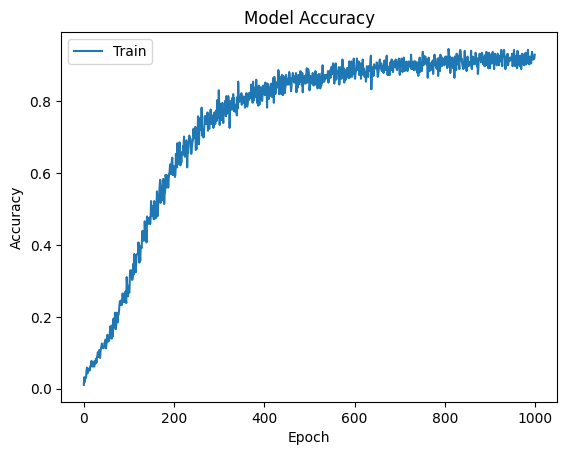

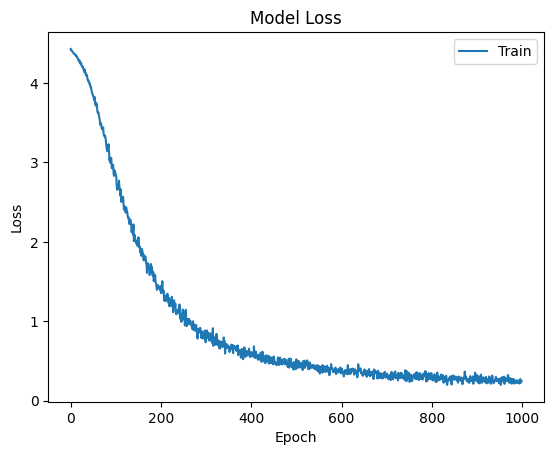

In [20]:
import matplotlib.pyplot as plt

# Plotting accuracy history
plt.plot(hist.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plotting loss history
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()
